In [2]:
import pandas as pd 
import torch
from chronos import ChronosPipeline, ChronosBoltPipeline
import matplotlib.pyplot as plt
import numpy as np


c:\Users\micha\code\finance\diploma\myenv-3-10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pipeline = ChronosBoltPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cpu",  
    torch_dtype=torch.bfloat16,
)

In [4]:
context_length = pipeline.model.config.n_positions  # Key change here

print(f"Context window: {context_length} time steps")

Context window: 512 time steps


In [5]:
df = pd.read_csv('data/INTC_1H.csv')
price_columns = ['Open', 'High', 'Low', 'Close']
df[price_columns] = df[price_columns].round(2)
print(len(df))
print(df.head())
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head()

3488
                    Datetime   Open   High    Low  Close   Volume  Dividends  \
0  2023-03-27 14:30:00-04:00  29.52  29.60  29.39  29.42        0        0.0   
1  2023-03-27 15:30:00-04:00  29.41  29.42  29.15  29.21  6123103        0.0   
2  2023-03-28 09:30:00-04:00  29.08  29.14  28.75  28.80  6001110        0.0   
3  2023-03-28 10:30:00-04:00  28.80  29.19  28.63  29.11  5362455        0.0   
4  2023-03-28 11:30:00-04:00  29.11  29.23  28.96  28.99  3354148        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  


C:\Users\micha\AppData\Local\Temp\ipykernel_9028\1311112096.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Datetime'] = pd.to_datetime(df['Datetime'])


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-03-27 14:30:00-04:00,29.52,29.60,29.39,29.42,0,0.0,0.0
1,2023-03-27 15:30:00-04:00,29.41,29.42,29.15,29.21,6123103,0.0,0.0
2,2023-03-28 09:30:00-04:00,29.08,29.14,28.75,28.80,6001110,0.0,0.0
3,2023-03-28 10:30:00-04:00,28.80,29.19,28.63,29.11,5362455,0.0,0.0
4,2023-03-28 11:30:00-04:00,29.11,29.23,28.96,28.99,3354148,0.0,0.0


In [6]:
input_df = df
input_df = pd.DataFrame({'unique_id':[1]*len(input_df),'ds': input_df["Datetime"], "y":input_df['Close']})
input_df

,unique_id,ds,y
0,1,2023-03-27 14:30:00-04:00,29.42
1,1,2023-03-27 15:30:00-04:00,29.21
2,1,2023-03-28 09:30:00-04:00,28.80
3,1,2023-03-28 10:30:00-04:00,29.11
4,1,2023-03-28 11:30:00-04:00,28.99
...,...,...,...
3483,1,2025-03-26 10:30:00-04:00,23.33
3484,1,2025-03-26 11:30:00-04:00,23.44
3485,1,2025-03-26 12:30:00-04:00,23.41
3486,1,2025-03-26 13:30:00-04:00,23.34


In [7]:
context_vrsta = torch.tensor(input_df['y'].values, dtype=torch.float32)


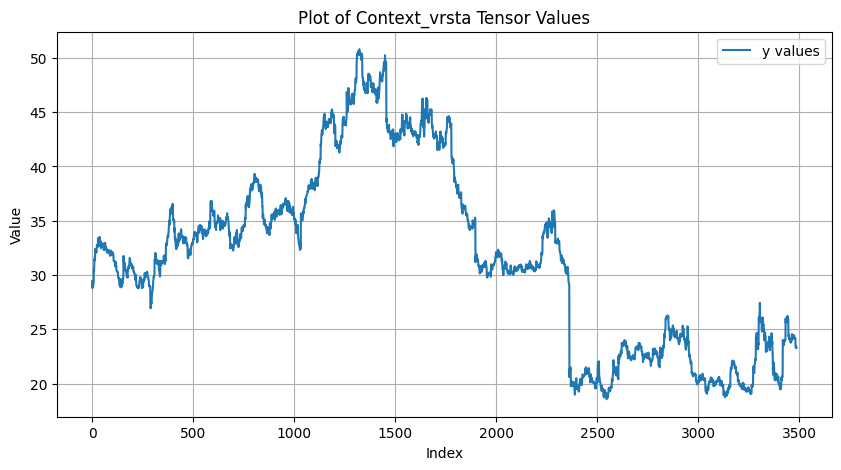

In [8]:
data_np = context_vrsta.detach().cpu().numpy()

# Create plot
plt.figure(figsize=(10, 5))
plt.plot(data_np, label='y values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of Context_vrsta Tensor Values')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
context_window = context_vrsta[:512]  # First 512 values

# Make prediction for next 128 steps
quantiles, mean = pipeline.predict_quantiles(
    context=context_window,
    prediction_length=128,
    quantile_levels=[0.1, 0.5, 0.9],
)


c:\Users\micha\code\finance\diploma\myenv-3-10\lib\site-packages\chronos\chronos_bolt.py:527: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


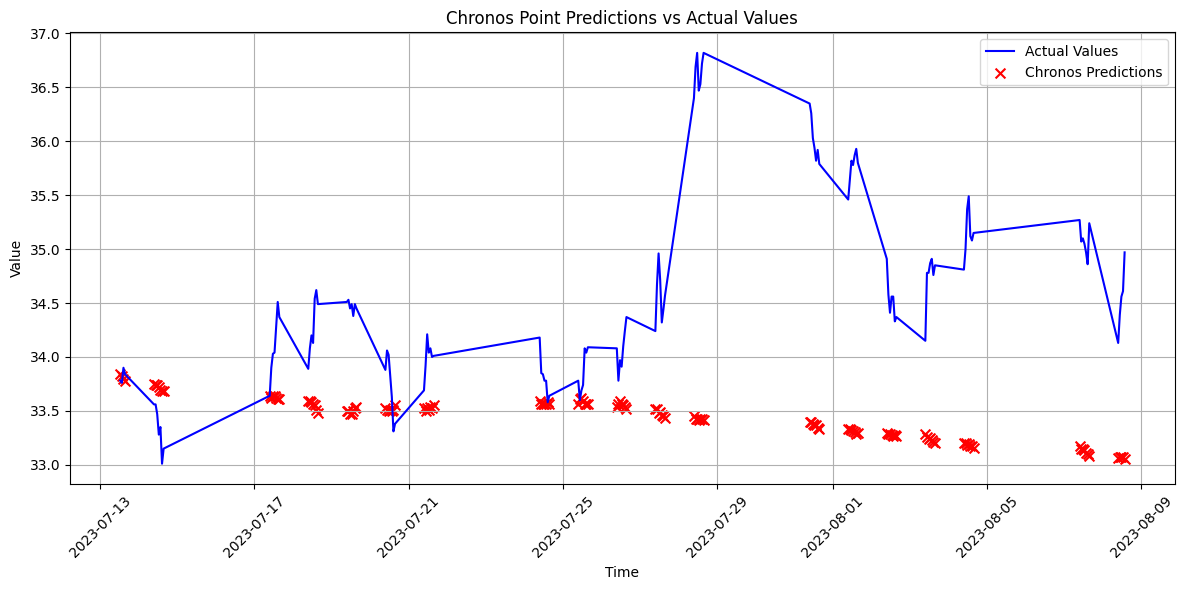

In [26]:
prediction_dates = input_df['ds'].iloc[512:512+128]  # Assuming 'ds' is your datetime column

plt.figure(figsize=(12, 6))

# Plot actual values as a continuous line
plt.plot(prediction_dates, context_vrsta[512:512+128].cpu().numpy(), 
         label='Actual Values', color='blue', linewidth=1.5)

# Plot Chronos predictions as distinct points
plt.scatter(prediction_dates, mean.squeeze().cpu().numpy(),
            label='Chronos Predictions', color='red', marker='x', s=50)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Chronos Point Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()
plt.show()

SyntaxError: positional argument follows keyword argument (429806035.py, line 21)